# Imports and data loading

In [53]:
import sourmash
import screed
import seaborn as sns
import os
import re
import pandas as pd
import numpy as np
import glob
from tqdm import tqdm
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from scipy.special import logsumexp
tqdm.pandas()


from kmer_utils import get_encoded_kmer_hashvals

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
outdir = '/Users/olgabot/botryllus/adhoc-analysis/2022-apr--gather-botryllus-in-human-mouse-with-kmers/'
# ! mkdir $outdir

In [4]:
%%time

gather_results = pd.read_parquet(
    os.path.join(outdir, "botryllus_gather_mouse_human_results.parquet")
)

CPU times: user 36 s, sys: 50.5 s, total: 1min 26s
Wall time: 1min 29s


### Subset to only human gather results

In [5]:
gather_results_human = gather_results.query('species == "human"')
gather_results_human

,i_query,kmer_query,kmer_hp,hashval,name_query,i_found,kmer_found,name_found,n_kmers,intersect_bp,containment,symbol,species,found_i,homolog_group,genomic_coord,all_homologs_found,transcript_id
0,150,YSFTLKDDTGEVVLDQWNKASLVP,hphphpppphphhhpphpphphhh,3018107519398277786,g25414.t1 frame:1,1238,PKISLRRSSLKYLGCRYSEIKPYG,ENST00000361833.7 gene_id=ENSG00000152092.16;t...,3,15,0.011583,ASTN1,human,0,ASTN1---Astn1,Chr1:176855118-177164904(-),False,ENST00000361833.7
1,151,SFTLKDDTGEVVLDQWNKASLVPG,phphpppphphhhpphpphphhhh,1234479950528962468,g25414.t1 frame:1,1239,KISLRRSSLKYLGCRYSEIKPYGL,ENST00000361833.7 gene_id=ENSG00000152092.16;t...,3,15,0.011583,ASTN1,human,0,ASTN1---Astn1,Chr1:176855118-177164904(-),False,ENST00000361833.7
2,152,FTLKDDTGEVVLDQWNKASLVPGK,hphpppphphhhpphpphphhhhp,2563348012698350512,g25414.t1 frame:1,1240,ISLRRSSLKYLGCRYSEIKPYGLD,ENST00000361833.7 gene_id=ENSG00000152092.16;t...,3,15,0.011583,ASTN1,human,0,ASTN1---Astn1,Chr1:176855118-177164904(-),False,ENST00000361833.7
3,15,NFHVGVKFVSSPKRGGVSQYLKGI,phphhhphhpphpphhhpphhphh,1046426320533182525,g25414.t1 frame:1,576,SVQPIVKLVSTATTAPPSTAPSGP,ENST00000453269.7 gene_id=ENSG00000106290.15;t...,2,10,0.015038,TAF6,human,1,TAF6---Taf6,Chr7:100107070-100119858(-),False,ENST00000453269.7
4,16,FHVGVKFVSSPKRGGVSQYLKGIF,hphhhphhpphpphhhpphhphhh,2154375574397474662,g25414.t1 frame:1,577,VQPIVKLVSTATTAPPSTAPSGPG,ENST00000453269.7 gene_id=ENSG00000106290.15;t...,2,10,0.015038,TAF6,human,1,TAF6---Taf6,Chr7:100107070-100119858(-),False,ENST00000453269.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3,19,NSWIFQDSVVIDTNDIAAWLRNKL,pphhhppphhhpppphhhhhppph,2741191184754143198,g5107.t1 frame:1,355,ETLILDSNPLACDCRLLWVFRRRW,ENST00000561030.5 gene_id=ENSG00000169783.13;t...,3,15,0.015267,LINGO1,human,1,LINGO1---Lingo1,Chr15:77613024-77820900(-),True,ENST00000561030.5
4,20,SWIFQDSVVIDTNDIAAWLRNKLN,phhhppphhhpppphhhhhppphp,312706106409923617,g5107.t1 frame:1,356,TLILDSNPLACDCRLLWVFRRRWR,ENST00000561030.5 gene_id=ENSG00000169783.13;t...,3,15,0.015267,LINGO1,human,1,LINGO1---Lingo1,Chr15:77613024-77820900(-),True,ENST00000561030.5
5,21,WIFQDSVVIDTNDIAAWLRNKLNV,hhhppphhhpppphhhhhppphph,5902042603803971015,g5107.t1 frame:1,357,LILDSNPLACDCRLLWVFRRRWRL,ENST00000561030.5 gene_id=ENSG00000169783.13;t...,3,15,0.015267,LINGO1,human,1,LINGO1---Lingo1,Chr15:77613024-77820900(-),True,ENST00000561030.5
6,57,HLFSDFFRHVRFRSFHDMALSRLR,phhpphhpphphpphpphhhpphp,2353047329972989606,g5107.t1 frame:1,230,KGVDTFLRRPNFTRATTVPLQTLS,ENST00000261584.9 gene_id=ENSG00000083093.10;t...,2,10,0.007519,PALB2,human,2,PALB2---Palb2,Chr16:23603162-23641357(-),False,ENST00000261584.9


In [6]:
del gather_results

# Get signature files

In [8]:
botryllus_dir = '/Users/olgabot/botryllus/data/botryllus-proteins/'

human_gencode_dir = '/Users/olgabot/botryllus/data/gencode/v38/'
mouse_gencode_dir = '/Users/olgabot/botryllus/data/gencode/M28/'

## set signature files

human_sigfile = os.path.join(
    human_gencode_dir, "gencode.v38.basic.annotation.protein.fa.hp.k24.scale5.sig"
)
mouse_sigfile = os.path.join(
    mouse_gencode_dir, "gencode.vM28.basic.annotation.protein.fa.hp.k24.scale5.sig"
)

botryllus_sigfile = os.path.join(botryllus_dir, 'Bs_proteins.fa.hp.k24.scale5.sig')

## Create non-singleton sourmash sketch

In [9]:
human_fasta = os.path.join(human_gencode_dir, "gencode.v38.basic.annotation.protein.fa")
human_sigfile_aggregated = os.path.join(
    human_gencode_dir,
    "gencode.v38.basic.annotation.protein.fa.hp.k24.scale5.aggregated.sig",
)
# ! time sourmash sketch protein --output $human_sigfile_aggregated --hp -p k=24,scaled=5,abund $human_fasta

In [19]:
human_sig = sourmash.load_one_signature(human_sigfile_aggregated)

### Read botryllus kmer hashes

In [10]:
def read_hash_csv(csv):
    df = pd.read_csv(csv)
    
    # Force hashval to be strings to avoid overflow/underflow errors
    df['hashval'] = df['hashval'].astype(str)
    df = df.set_index(['hashval'])
    return df

In [11]:
csv = os.path.join(botryllus_dir, 'Bs_proteins.fa.hp.k24.scale5.aggregated.kmers.csv')
botryllus_kmer_hashes = read_hash_csv(csv)
# botryllus_kmer_hashes.index = botryllus_kmer_hashes.index.astype(str)
botryllus_kmer_hashes

,kmer_in_sequence,kmer_in_alphabet,read_name,filename
hashval,,,,
1036020595944595459,VHDTEQLLAQGHHEEETECGKYGK,hppppphhhphpppppppphphhp,BHF,Bs_proteins.fa.gz
2993707203445337902,TEQLLAQGHHEEETECGKYGKLPE,ppphhhphpppppppphphhphhp,BHF,Bs_proteins.fa.gz
973051056292048589,EQLLAQGHHEEETECGKYGKLPEK,pphhhphpppppppphphhphhpp,BHF,Bs_proteins.fa.gz
385192726330471768,ETECGKYGKLPEKGSECKKHGIFC,pppphphhphhpphpppppphhhp,BHF,Bs_proteins.fa.gz
1194029314525711201,KYGKLPEKGSECKKHGIFCRILTA,phhphhpphpppppphhhpphhph,BHF,Bs_proteins.fa.gz
...,...,...,...,...
1833930335722081195,LEREIEAQQLVMLEAEIDCLQRRF,hppphphpphhhhphphpphppph,g72096.t1 frame:1,Bs_proteins.fa.gz
616964295969867237,EREIEAQQLVMLEAEIDCLQRRFE,ppphphpphhhhphphpphppphp,g72096.t1 frame:1,Bs_proteins.fa.gz
1869927996039995699,MLEAEIDCLQRRFEDMESTWISRI,hhphphpphppphpphppphhpph,g72096.t1 frame:1,Bs_proteins.fa.gz


In [15]:
human_gencode_dir = '/Users/olgabot/botryllus/data/gencode/v38/'
mouse_gencode_dir = '/Users/olgabot/botryllus/data/gencode/M28/'
human_kmers_csv = os.path.join(
    human_gencode_dir,
    "gencode.v38.basic.annotation.protein.fa.hp.k24.scale5.aggregated.kmers.csv",
)

human_kmer_hashes = read_hash_csv(human_kmers_csv)
# human_kmer_hashes.index = human_kmer_hashes.index.astype(str)
human_kmer_hashes

,kmer_in_sequence,kmer_in_alphabet,read_name,filename
hashval,,,,
3438741737707008236,AEAISWNESTSETNNSMVTEFIFL,hphhphpppppppppphhpphhhh,ENST00000641515.2 gene_id=ENSG00000186092.7;tr...,/Users/olgabot/botryllus/data/gencode/v38/genc...
2304868333845493775,SWNESTSETNNSMVTEFIFLGLSD,phpppppppppphhpphhhhhhpp,ENST00000641515.2 gene_id=ENSG00000186092.7;tr...,/Users/olgabot/botryllus/data/gencode/v38/genc...
773785692324772595,ETNNSMVTEFIFLGLSDSQELQTF,ppppphhpphhhhhhppppphpph,ENST00000641515.2 gene_id=ENSG00000186092.7;tr...,/Users/olgabot/botryllus/data/gencode/v38/genc...
2297609714666314612,TNNSMVTEFIFLGLSDSQELQTFL,pppphhpphhhhhhppppphpphh,ENST00000641515.2 gene_id=ENSG00000186092.7;tr...,/Users/olgabot/botryllus/data/gencode/v38/genc...
1737326980818371865,NNSMVTEFIFLGLSDSQELQTFLF,ppphhpphhhhhhppppphpphhh,ENST00000641515.2 gene_id=ENSG00000186092.7;tr...,/Users/olgabot/botryllus/data/gencode/v38/genc...
...,...,...,...,...
963288537120590718,NIVPIAILVFAACEAAVGLALLVS,phhhhhhhhhhhpphhhhhhhhhp,ENST00000361335.1 gene_id=ENSG00000212907.2;tr...,/Users/olgabot/botryllus/data/gencode/v38/genc...
1219365156401211377,AACEAAVGLALLVSISNTYGLDYV,hhpphhhhhhhhhphppphhhphh,ENST00000361335.1 gene_id=ENSG00000212907.2;tr...,/Users/olgabot/botryllus/data/gencode/v38/genc...
3243920481552129892,CEAAVGLALLVSISNTYGLDYVHN,pphhhhhhhhhphppphhhphhpp,ENST00000361335.1 gene_id=ENSG00000212907.2;tr...,/Users/olgabot/botryllus/data/gencode/v38/genc...


# Make pandas series of hashes

In [21]:
%%time
human_minhashes = pd.Series(human_sig.minhash.hashes, name='human')
human_minhashes.index = human_minhashes.index.astype(str)

CPU times: user 2.61 s, sys: 183 ms, total: 2.79 s
Wall time: 2.8 s


In [22]:
human_minhashes.describe()

count    1.521355e+06
mean     4.074873e+00
std      7.673557e+00
min      1.000000e+00
25%      2.000000e+00
50%      3.000000e+00
75%      5.000000e+00
max      7.222000e+03
Name: human, dtype: float64

In [23]:
botryllus_sigfile_aggregated = os.path.join(
    botryllus_dir, "Bs_proteins.fa.hp.k24.scale5.aggregated.sig"
)
botryllus_sig = sourmash.load_one_signature(botryllus_sigfile_aggregated)

In [25]:
%%time
botryllus_minhashes = pd.Series(botryllus_sig.minhash.hashes, name='botryllus')
botryllus_minhashes.index = botryllus_minhashes.index.astype(str)

CPU times: user 2.56 s, sys: 140 ms, total: 2.7 s
Wall time: 2.7 s


In [26]:
botryllus_minhashes.describe()

count    1.499641e+06
mean     2.041660e+00
std      3.646242e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      1.535000e+03
Name: botryllus, dtype: float64

In [27]:
botryllus_kmer_hashes

,kmer_in_sequence,kmer_in_alphabet,read_name,filename
hashval,,,,
1036020595944595459,VHDTEQLLAQGHHEEETECGKYGK,hppppphhhphpppppppphphhp,BHF,Bs_proteins.fa.gz
2993707203445337902,TEQLLAQGHHEEETECGKYGKLPE,ppphhhphpppppppphphhphhp,BHF,Bs_proteins.fa.gz
973051056292048589,EQLLAQGHHEEETECGKYGKLPEK,pphhhphpppppppphphhphhpp,BHF,Bs_proteins.fa.gz
385192726330471768,ETECGKYGKLPEKGSECKKHGIFC,pppphphhphhpphpppppphhhp,BHF,Bs_proteins.fa.gz
1194029314525711201,KYGKLPEKGSECKKHGIFCRILTA,phhphhpphpppppphhhpphhph,BHF,Bs_proteins.fa.gz
...,...,...,...,...
1833930335722081195,LEREIEAQQLVMLEAEIDCLQRRF,hppphphpphhhhphphpphppph,g72096.t1 frame:1,Bs_proteins.fa.gz
616964295969867237,EREIEAQQLVMLEAEIDCLQRRFE,ppphphpphhhhphphpphppphp,g72096.t1 frame:1,Bs_proteins.fa.gz
1869927996039995699,MLEAEIDCLQRRFEDMESTWISRI,hhphphpphppphpphppphhpph,g72096.t1 frame:1,Bs_proteins.fa.gz


In [28]:
botryllus_minhashes_freq = botryllus_minhashes/botryllus_minhashes.sum()
human_minhashes_freq = human_minhashes/human_minhashes.sum()

In [29]:
botryllus_minhashes_freq.describe()

count    1.499641e+06
mean     6.668263e-07
std      1.190899e-06
min      3.266099e-07
25%      3.266099e-07
50%      3.266099e-07
75%      6.532197e-07
max      5.013461e-04
Name: botryllus, dtype: float64

In [30]:
human_minhashes_freq.describe()

count    1.521355e+06
mean     6.573088e-07
std      1.237804e-06
min      1.613078e-07
25%      3.226156e-07
50%      4.839233e-07
75%      8.065389e-07
max      1.164965e-03
Name: human, dtype: float64

In [31]:
human_minhashes_freq[human_minhashes_freq > 1e-4]

248203946111836632     0.000128
853878169790340257     0.001165
1176596621400818277    0.000150
2621898202634985687    0.000101
3640030393541500537    0.000124
Name: human, dtype: float64

In [32]:
botryllus_minhashes_freq.head().index

Index(['4949352718893', '11590100102600', '13829197037459', '19131220625210',
       '26163028921650'],
      dtype='object')

In [36]:
human_minhashes_freq_top10 = human_minhashes_freq.nlargest(10)
human_minhashes_freq_top10

853878169790340257     0.001165
1176596621400818277    0.000150
248203946111836632     0.000128
3640030393541500537    0.000124
2621898202634985687    0.000101
2384756448698727573    0.000087
2037292660785240141    0.000086
2892598906749835812    0.000079
952514893579374774     0.000074
364208822315268762     0.000073
Name: human, dtype: float64

In [37]:
# human_kmer_hashes.drop_duplicates?

In [38]:
human_kmer_hashes.loc[human_minhashes_freq_top10.index].drop_duplicates(subset=['kmer_in_alphabet'])

,kmer_in_sequence,kmer_in_alphabet,read_name,filename
hashval,,,,
853878169790340257,DKDKDKDKEKDRDRDRDREREKRD,pppppppppppppppppppppppp,ENST00000337907.7 gene_id=ENSG00000142599.19;t...,/Users/olgabot/botryllus/data/gencode/v38/genc...
1176596621400818277,ADKDKDKDKEKDRDRDRDREREKR,hppppppppppppppppppppppp,ENST00000337907.7 gene_id=ENSG00000142599.19;t...,/Users/olgabot/botryllus/data/gencode/v38/genc...
248203946111836632,KDKDKEKDRDRDRDREREKRDKAR,pppppppppppppppppppppphp,ENST00000337907.7 gene_id=ENSG00000142599.19;t...,/Users/olgabot/botryllus/data/gencode/v38/genc...
3640030393541500537,HQRIHTGEKPYDCNECGKAFSCSS,ppphpphpphhppppphphhpppp,ENST00000411995.6 gene_id=ENSG00000187801.15;t...,/Users/olgabot/botryllus/data/gencode/v38/genc...
2621898202634985687,FAKHQRIHTGEKPYDCNECGKAFS,hhpppphpphpphhppppphphhp,ENST00000411995.6 gene_id=ENSG00000187801.15;t...,/Users/olgabot/botryllus/data/gencode/v38/genc...
2384756448698727573,GGRAVAAILGLGLVLGLLGPLAIL,hhphhhhhhhhhhhhhhhhhhhhh,ENST00000379236.4 gene_id=ENSG00000186827.11;t...,/Users/olgabot/botryllus/data/gencode/v38/genc...
2037292660785240141,NSDLVRHRRAHTGEKPYHCNECGE,ppphhpppphpphpphhppppphp,ENST00000314011.9 gene_id=ENSG00000125945.15;t...,/Users/olgabot/botryllus/data/gencode/v38/genc...
2892598906749835812,SEESEEEEEEEEEEEEETGSNSEE,pppppppppppppppppphppppp,ENST00000341832.11 gene_id=ENSG00000248333.9;t...,/Users/olgabot/botryllus/data/gencode/v38/genc...
952514893579374774,SSFAKHQRIHTGEKPYDCNECGKA,pphhpppphpphpphhppppphph,ENST00000411995.6 gene_id=ENSG00000187801.15;t...,/Users/olgabot/botryllus/data/gencode/v38/genc...


In [39]:
botryllus_minhashes_freq_top10 = botryllus_minhashes_freq.nlargest(10)
botryllus_minhashes_freq_top10

853878169790340257     0.000501
3408350120326268046    0.000127
1832506267497687492    0.000122
1083907595478869357    0.000122
2382895590170336395    0.000120
3538013662285724268    0.000115
2451121932896149445    0.000114
2591393804842303278    0.000105
463972956607222480     0.000105
2769326808692211423    0.000103
Name: botryllus, dtype: float64

In [40]:
botryllus_kmer_hashes.loc[
    botryllus_minhashes_freq_top10.index
].drop_duplicates("kmer_in_alphabet")

,kmer_in_sequence,kmer_in_alphabet,read_name,filename
hashval,,,,
853878169790340257,SRKHQRRRRSRSKKRRRSSSRERR,pppppppppppppppppppppppp,g574.t1 frame:1,Bs_proteins.fa.gz
3408350120326268046,DFFTSESKAHKYNTRASTSSKYHM,phhppppphpphppphppppphph,g9249.t1 frame:1,Bs_proteins.fa.gz
1832506267497687492,YHMIDRKDHRSIKYAGPDVWNSIP,hphhppppppphphhhhphhpphh,g9249.t1 frame:1,Bs_proteins.fa.gz
1083907595478869357,KAHKYNTRASTSSKYHMIDRKDHR,phpphppphppppphphhpppppp,g9249.t1 frame:1,Bs_proteins.fa.gz
2382895590170336395,HMIDRKDHRSIKYAGPDVWNSIPP,phhppppppphphhhhphhpphhh,g9249.t1 frame:1,Bs_proteins.fa.gz
3538013662285724268,GRCPEYFNDFFTSESKAHKYNTRA,hpphphhpphhppppphpphppph,g1306.t1 frame:1,Bs_proteins.fa.gz
2451121932896149445,YFNDFFTSESKAHKYNTRASTSSK,hhpphhppppphpphppphppppp,g9249.t1 frame:1,Bs_proteins.fa.gz
2591393804842303278,GPDVWNNILPAIRQSTSMSCPRSS,hhphhpphhhhhppppphpphppp,g7520.t1 frame:1,Bs_proteins.fa.gz
463972956607222480,AGPDVWNNILPAIRQSTSMSCPRS,hhhphhpphhhhhppppphpphpp,g7520.t1 frame:1,Bs_proteins.fa.gz


/Users/olgabot/opt/miniconda3/envs/botryllus/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/olgabot/opt/miniconda3/envs/botryllus/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='human', ylabel='Density'>

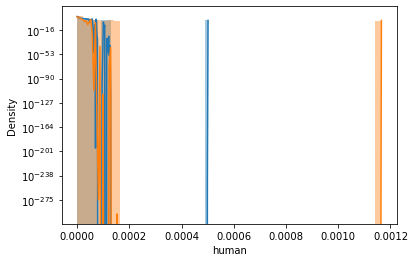

In [41]:
fig, ax = plt.subplots()
ax.set_yscale('log')
sns.distplot(botryllus_minhashes_freq, label='botryllus', ax=ax)
sns.distplot(human_minhashes_freq, label='human', ax=ax)


# Compute probability of overlap given underlying k-mer distribution

In [43]:
gather_results_subset = gather_results_human.head(100)
len(gather_results_subset.groupby(['name_query', 'name_found']))

27

In [46]:
botryllus_minhashes_freq_log = np.log(botryllus_minhashes_freq)
human_minhashes_freq_log = np.log(botryllus_minhashes_freq)

In [49]:
np.exp(-13.142740)

1.959659155694698e-06

In [75]:
    def get_prob_overlap(df, freq_a, freq_b, logged=False):
        # import pdb; pdb.set_trace()
        hashes = df["hashval"].values

        # Not all hashes are present for some reason -> take the intersection for now while I figure that bug out
        # Was something done at scaled=10 maybe? and then this is scaled=5 which has half the k-mers?
        observed_hashes = freq_a.index.intersection(freq_b.index.intersection(hashes))
        if observed_hashes.empty:
            return 0

        freq_a_subset = freq_a[observed_hashes]
        freq_b_subset = freq_b[observed_hashes]
        if logged:
            # Log-probabilities to prevent underflow
            log_probabilities = np.logaddexp(freq_a_subset, freq_b_subset)
            prob_overlap = logsumexp(log_probabilities)
            # import pdb; pdb.set_trace()
        else:
            # Raw probabilities
            prob_overlap = freq_a_subset.multiply(freq_b_subset).sum()

        return prob_overlap


gather_results_subset.groupby(["name_query", "name_found"]).apply(
    lambda x: get_prob_overlap(
        x, botryllus_minhashes_freq_log, human_minhashes_freq_log, logged=True
    )
)

name_query         name_found                                                                                                                                                                                                                                                                                                                                                                                                                                       
g22187.t1 frame:1  ENST00000263915.8 gene_id=ENSG00000115290.10;transcript_id=ENST00000263915.8;gene_type=protein_coding;gene_name=GRB14;transcript_type=protein_coding;transcript_name=GRB14-201;level=2;protein_id=ENSP00000263915.3;transcript_support_level=1;hgnc_id=HGNC:4565;tag=basic,Ensembl_canonical,MANE_Select,appris_principal_1,CCDS;ccdsid=CCDS2222.1;havana_gene=OTTHUMG00000132135.8;havana_transcript=OTTHUMT00000255180.3                          -12.449593
                   ENST00000264057.7 gene_id=ENSG00000077044.11;transcript_id=ENS

In [77]:
human_botryllus_kmer_probs = gather_results_human.groupby(
    ["name_query", "name_found"]
).progress_apply(
    lambda x: get_prob_overlap(
        x, botryllus_minhashes_freq_log, human_minhashes_freq_log, logged=True
    )
)
human_botryllus_kmer_probs

  0%|          | 0/577598 [00:00<?, ?it/s]

name_query  name_found                                                                                                                                                                                                                                                                                                                                                                                                                                   
BHF         ENST00000216832.9 gene_id=ENSG00000100941.9;transcript_id=ENST00000216832.9;gene_type=protein_coding;gene_name=PNN;transcript_type=protein_coding;transcript_name=PNN-201;level=2;protein_id=ENSP00000216832.4;transcript_support_level=1;hgnc_id=HGNC:9162;tag=basic,Ensembl_canonical,MANE_Select,appris_principal_1,CCDS;ccdsid=CCDS9671.1;havana_gene=OTTHUMG00000028821.6;havana_transcript=OTTHUMT00000276776.3                           -12.855058
            ENST00000234296.7 gene_id=ENSG00000115942.9;transcript_id=ENST00000234296.7;gene_type=prote

In [67]:
human_botryllus_kmer_probs.head()

name_query  name_found                                                                                                                                                                                                                                                                                                                                                                                                                                   
BHF         ENST00000216832.9 gene_id=ENSG00000100941.9;transcript_id=ENST00000216832.9;gene_type=protein_coding;gene_name=PNN;transcript_type=protein_coding;transcript_name=PNN-201;level=2;protein_id=ENSP00000216832.4;transcript_support_level=1;hgnc_id=HGNC:9162;tag=basic,Ensembl_canonical,MANE_Select,appris_principal_1,CCDS;ccdsid=CCDS9671.1;havana_gene=OTTHUMG00000028821.6;havana_transcript=OTTHUMT00000276776.3                            1.386295
            ENST00000234296.7 gene_id=ENSG00000115942.9;transcript_id=ENST00000234296.7;gene_type=protei

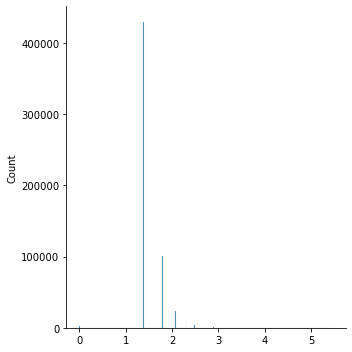

In [74]:
sns.displot(human_botryllus_kmer_probs)

In [68]:
n_comparisons = len(human_botryllus_kmer_probs)
n_comparisons

577598

In [69]:
# Log probabilities -> Add the number of comparisions
human_botryllus_kmer_probs_adjusted = human_botryllus_kmer_probs+n_comparisons
human_botryllus_kmer_probs_adjusted

name_query  name_found                                                                                                                                                                                                                                                                                                                                                                                                                                   
BHF         ENST00000216832.9 gene_id=ENSG00000100941.9;transcript_id=ENST00000216832.9;gene_type=protein_coding;gene_name=PNN;transcript_type=protein_coding;transcript_name=PNN-201;level=2;protein_id=ENSP00000216832.4;transcript_support_level=1;hgnc_id=HGNC:9162;tag=basic,Ensembl_canonical,MANE_Select,appris_principal_1,CCDS;ccdsid=CCDS9671.1;havana_gene=OTTHUMG00000028821.6;havana_transcript=OTTHUMT00000276776.3                            577599.386295
            ENST00000234296.7 gene_id=ENSG00000115942.9;transcript_id=ENST00000234296.7;gene_type=p

In [70]:
human_botryllus_kmer_probs_adjusted.describe()

count    577598.000000
mean     577599.525416
std           0.320700
min      577598.000000
25%      577599.386295
50%      577599.386297
75%      577599.791760
max      577603.463833
dtype: float64

In [71]:
np.log10(human_botryllus_kmer_probs_adjusted).describe()

count    5.775980e+05
mean     5.761627e+00
std      2.411325e-07
min      5.761626e+00
25%      5.761627e+00
50%      5.761627e+00
75%      5.761627e+00
max      5.761630e+00
dtype: float64

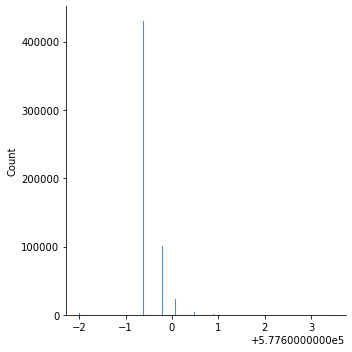

In [73]:
sns.displot(human_botryllus_kmer_probs_adjusted)